In [330]:
import pandas as pd
import re
from copy import copy
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
import nltk
from nltk.collocations import *
from random import choice
import numpy as np
import matplotlib as plt
from wordcloud import WordCloud
from sklearn.metrics import silhouette_score, silhouette_samples
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# a, b

In [2]:
data = pd.read_csv('Emails.csv')
data.RawText = map(lambda s: s.split('\n'), data.RawText)
data.head()

Id  DocNumber                                    MetadataSubject  \
0   1  C05739545                                                WOW   
1   2  C05739546  H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...   
2   3  C05739547                                      CHRIS STEVENS   
3   4  C05739550                         CAIRO CONDEMNATION - FINAL   
4   5  C05739554  H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...   

     MetadataTo       MetadataFrom  SenderPersonId           MetadataDateSent  \
0             H  Sullivan, Jacob J            87.0  2012-09-12T04:00:00+00:00   
1             H                NaN             NaN  2011-03-03T05:00:00+00:00   
2            ;H    Mills, Cheryl D            32.0  2012-09-12T04:00:00+00:00   
3             H    Mills, Cheryl D            32.0  2012-09-12T04:00:00+00:00   
4  Abedin, Huma                  H            80.0  2011-03-11T05:00:00+00:00   

        MetadataDateReleased  \
0  2015-05-22T04:00:00+00:00   
1  2015-05-22T04:00:00+00:00   
2  2015-05-22T04:00:00+00:00   
3  2015-05-22T04:00:00+00:00   
4  2015-05-22T04:00:00+00:00   

                                     MetadataPdfLink MetadataCaseNumber  \
0  DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...       F-2015-04841   
1  DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...       F-2015-04841   
2  DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...       F-2015-04841   
3  DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...       F-2015-04841   
4  DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...       F-2015-04841   

                         ...                         ExtractedTo  \
0                        ...                                 NaN   
1                        ...                                 NaN   
2                        ...                                  B6   
3                        ...                                 NaN   
4                        ...                                 NaN   

                              ExtractedFrom         ExtractedCc  \
0  Sullivan, Jacob J <Sullivan11@state.gov>                 NaN   
1                                       NaN                 NaN   
2       Mills, Cheryl D <MillsCD@state.gov>        Abedin, Huma   
3       Mills, Cheryl D <MillsCD@state.gov>  Mitchell, Andrew B   
4                                       NaN                 NaN   

                        ExtractedDateSent ExtractedCaseNumber  \
0  Wednesday, September 12, 2012 10:16 AM        F-2015-04841   
1                                     NaN        F-2015-04841   
2  Wednesday, September 12, 2012 11:52 AM        F-2015-04841   
3   Wednesday, September 12,2012 12:44 PM        F-2015-04841   
4                                     NaN        F-2015-04841   

  ExtractedDocNumber ExtractedDateReleased ExtractedReleaseInPartOrFull  \
0          C05739545            05/13/2015              RELEASE IN FULL   
1          C05739546            05/13/2015              RELEASE IN PART   
2          C05739547            05/14/2015              RELEASE IN PART   
3          C05739550            05/13/2015              RELEASE IN PART   
4          C05739554            05/13/2015              RELEASE IN PART   

                                   ExtractedBodyText  \
0                                                NaN   
1  B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...   
2                                                Thx   
3                                                NaN   
4  H <hrod17@clintonemail.com>\nFriday, March 11,...   

                                             RawText  
0  [UNCLASSIFIED, U.S. Department of State, Case ...  
1  [UNCLASSIFIED, U.S. Department of State, Case ...  
2  [UNCLASSIFIED, U.S. Department of State, Case ...  
3  [UNCLASSIFIED, U.S. Department of State, Case ...  
4  [B6, UNCLASSIFIED, U.S. Department of State, C...  

[5 rows x 22 columns]

Посмотрим, какие есть поля.

In [3]:
data.columns

Index([u'Id', u'DocNumber', u'MetadataSubject', u'MetadataTo', u'MetadataFrom',
       u'SenderPersonId', u'MetadataDateSent', u'MetadataDateReleased',
       u'MetadataPdfLink', u'MetadataCaseNumber', u'MetadataDocumentClass',
       u'ExtractedSubject', u'ExtractedTo', u'ExtractedFrom', u'ExtractedCc',
       u'ExtractedDateSent', u'ExtractedCaseNumber', u'ExtractedDocNumber',
       u'ExtractedDateReleased', u'ExtractedReleaseInPartOrFull',
       u'ExtractedBodyText', u'RawText'],
      dtype='object')

# c

Решила оставить тему, id sender, дату, и текст письма - эти поля мне кажутся наиболее информативными.

In [4]:
data_to_analyze = data[['MetadataSubject', 'SenderPersonId', 'MetadataDateSent', 'ExtractedBodyText']].dropna()

In [5]:
texts = copy(data.RawText)

Так как поле текста письма содержит много мусора, попробуем удалить все лишнее.

In [6]:
weeks_days =  '|'.join(['Monday' , 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
months = '|'.join(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
               'October', 'November', 'December'])
time = '[0-9]{1,2}, 20[0-9]{2} [0-9]{1,2}:[0-9]{2} AM'
time2 = '[0-9]{1,2}, 20[0-9]{2} [0-9]{1,2}:[0-9]{2} PM'
date = '[0-9]{2}/[0-9]{2}/[0-9]{4}'
number = 'No. [A-Z][0-9,-]*'
# date_pattern =  '[' + weeks_days + '], [' + months + '] [0-9]{1,2}, 20[0-9]{2} [0-9]{1,2}:[0-9]{2} PM'

In [7]:
def does_not_contain_trash(phrase, trash = {'Case', 'From', 'To', 'UNCLASSIFIED', 
                                            'Sent', 'Date', 'Doc', 'U.S. Department',
                                           'STATE DEPT', 'SUBJECT TO', 'RELEASE', '\x0c',
                                            'March', 'January', 'February', 'April', 'May',
                                           'June', 'July', 'August', 'September', 'October',
                                           'November', 'December', 'Cc', 'Monday', 'Tuesday', 
                                           'Wednesday', 'Thursday', 'Friday', 'Saturday', 
                                            'Sunday', 'Re', 'cc'}):
    for tr in trash:
        if phrase.startswith(tr):
            return False
    
    return True

In [8]:
def delete_trash(phrase, trash_patterns = {'Subject:', 'Subject', 'Case', 'From', 'To', 'UNCLASSIFIED',
                                            'Sent:', 'Date', 'Doc', 'U.S. Department',
                                           'STATE DEPT', 'SUBJECT TO', 'RELEASE', '\x0c', 'Fw:',
                                            'Cc',  'Re', 'cc', '\<(.*?)\>', 'H',
                                           '\n\n', number, ':{\s}{>0}\n', ',{\s}{>1}', '{\s}{>1}', '{\n}{>1}', 
                                          time2}):
    
    for tr in trash_patterns:
        phrase = re.sub(tr, '', phrase)
    
    return phrase

In [9]:
def not_space(phrase):
    return phrase != ' ' and phrase != ''

In [10]:
texts = map(lambda s: filter(does_not_contain_trash, s), data.RawText)
texts = map(lambda s: filter(not_space, s), texts)
texts = map(lambda s: map(lambda t: delete_trash(t), s), texts)
texts = map(lambda s: ' '.join(s), texts)

In [11]:
data_to_analyze.ExtractedBodyText = data_to_analyze.ExtractedBodyText.apply(delete_trash)

Посмотрим на результат.

In [12]:
for i in range(10, 15):
    index = choice(data_to_analyze.index)
    print choice(texts)
    print '----------------------------------------------------------'

B5 DRAFT 09/16/09 DS A New Approach for Missile Defense By illary Clinton DRAFT 09/16/09 DS 2 DRAFT 09/16/09 DS DRAFT 09/16/09 DS 4
----------------------------------------------------------
B6  Mills, Cheryl D   A little positive reinforcement to pass on to the S See below  A little positive reinforcement to pass on to the S Pamela was at the dinner.  Congratulations! Francisco, Just wanted to congratulate you and the entire team on a striking suess. The Secretary's visit was jaw-dropping from the Mexican perspective. I have never seen such a positive reaction to a visit by a high ranking US government official. My personal favorite: Estamos hillarizados por estos dias. There is obviously also a "show me the money" aspect of the reaction, but even Mexico's newspaper of the traditionally anti-American left editorialized about "Good Clinton, Bad Napolitano". And inside President Calderon's circle they are thrilled with Wednesday's meeting. Many congratulations. OK, I will stop bothering

# d

Найдем самую часто встречающуюся биграмму:

In [13]:
vectorizer = CountVectorizer(ngram_range=(2,2))
corpus = vectorizer.fit_transform(data_to_analyze.ExtractedBodyText)
sum_biwords = np.array(corpus.sum(axis=0))[0]
sum_biwords.argmax()

148695

In [14]:
filter(lambda s: vectorizer.vocabulary_[s] == sum_biwords.argmax(), vectorizer.vocabulary_.keys())

[u'of the']

'of the' - кажется вполне адекватным.

# e

In [13]:
with open('hillary_letters.txt', 'w') as f:
    for text in texts:
        for word in text.split():
            f.write(word + '\n')

In [14]:
finder = BigramCollocationFinder.from_words(nltk.corpus.genesis.words('./hillary_letters.txt'), window_size=2)
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [15]:
for bigram in finder.nbest(bigram_measures.pmi, 10):
    print bigram[0], bigram[1]

!.: tam
"> 123456789101112131415161718192021222324252627282930
"\ Nikileaks
%-=, B3196287623454
%.... 26d
%: prtArg
',..' esources
'.;. tiPCY
(.. ttlt1er
(..; krt


## f

In [21]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

In [199]:
vectorizer = TfidfVectorizer(max_features=1000)
corpus = vectorizer.fit_transform(texts)

In [200]:
num_classes = 3
clusterizer = KMeans(n_clusters=num_classes)
%time y = clusterizer.fit_predict(corpus)

CPU times: user 1min 5s, sys: 36 ms, total: 1min 5s
Wall time: 1min 5s


In [201]:
tsne = TSNE()
X_tsne = tsne.fit_transform(corpus.todense())

In [322]:
cm?

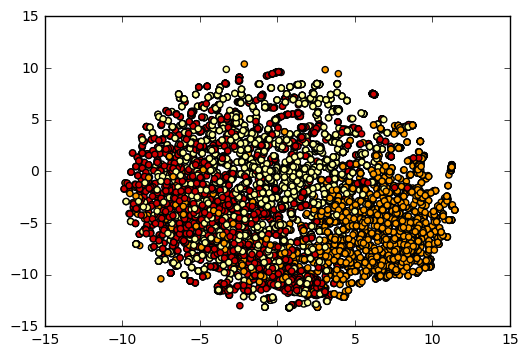

In [202]:
color_dict = cm.hot(np.linspace(0.3, 0.9, num_classes))
plt.figure()
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=color_dict[y])
plt.show()

In [204]:
silhouette_score(corpus, y)

0.031642583014113553

# g

Решила выделить в каждом кластере топ наиболее часто встречающихся слов и визуализировать только те из них, которых нет в топе других кластеров (также убираются союзы и предлоги). Для визуализации слов использовала код библиотеки wordcloud.

In [158]:
def create_index_to_word_dict(vectorizer):
    index_to_word = dict()
    for word, index in vectorizer.vocabulary_.iteritems():
        index_to_word[index] = word

    return index_to_word

In [159]:
def get_clouds_words(corpus, index_to_word, top_k=30, num_classes=3):
    top_classes_words = list()
    nearest_to_centr = list()
    top_words_scores = dict()

    for i in range(num_classes):
        top_classes_words.append(set())
        class_corpus = corpus[np.where(y == i)]
        class_mean = np.array(class_corpus.mean(axis=0))[0]
        #nearest_neighbour_index = np.argmin(np.power(corpus - class_mean, 2).sum(axis=1))
        #nearest_to_centr.append(nearest_neighbour_index)

        top_k_scores = sorted(class_mean)[-top_k:]
        top_k_indecies = filter(lambda i: class_mean[i] in top_k_scores, range(class_mean.shape[0]))

        if len(top_k_indecies) > top_k:
            top_k_indecies = list(set(choice(top_k_indecies, size=top_k)))

        for index in top_k_indecies:
            top_classes_words[-1].add(index_to_word[index])
            top_words_scores[index_to_word[index]] = class_mean[index]

    top_classes_words2 = copy(top_classes_words)

    for i in range(num_classes):
        other_classes_words = set()

        if top_classes_words2[:i] != []:
            other_classes_words = other_classes_words.union(*top_classes_words2[:i])

        if top_classes_words2[i+1:] != []:
            other_classes_words = other_classes_words.union(*top_classes_words2[i+1:])

        top_classes_words[i] = top_classes_words[i].difference(other_classes_words)
        
    return top_classes_words, top_words_scores

In [369]:
def create_frequency_string(word_voc, frequency_dict=top_words_scores):
    string_ = ''
    for word in word_voc:
        word_fr = ' '.join([word] * (int(top_words_scores[word] * 100) + 1))
        string_ = string_ + ' ' + word_fr
    return string_ 

def show_words_clusters(X, y,  top_classes_words, top_words_scores, normalize=True, num_classes=None, 
                        eps=0.1, figsize=(15,15), img_size=800, rel_scale=0.9, pref_hor=0.9, max_font=40,
                       max_words_in_cloud=10, centr_coef = 0.3):
    if num_classes is None:
        num_classes = len(set(y))
    
    if normalize:
        X_show = (X - np.min(X, axis=0)) / (np.max(X, axis=0) + eps)
    else:
        X_show = np.copy(X)
    
    centres = np.array([X_show[np.where(y == 0)].mean(axis=0),])
    for class_numb in range(1, num_classes):
        centres = np.concatenate([centres, list([X_show[np.where(y == class_numb)].mean(axis=0),])])
    
    fig = plt.figure(figsize=figsize)
    fig.patch.set_facecolor('black')

    color_dict = cm.hot(np.linspace(0.3, 0.9, num_classes))
    plt.scatter(X_show[:,0], X_show[:, 1], c=color_dict[y], alpha=0.3)

    for class_id in range(num_classes):
        class_words_fr_str = create_frequency_string(top_classes_words[class_id], top_words_scores)
        wcloud = WordCloud(height=img_size, width=img_size, relative_scaling=rel_scale,
                            prefer_horizontal=pref_hor,  max_font_size=max_font)

        # print class_words_fr_str
        wcloud.generate(class_words_fr_str)
        x_centr, y_centr = centres[class_id]
        for word, font_size, position, orientation, color in wcloud.layout_[:max_words_in_cloud]:

            plt.text(x_centr + (position[0] * 1. - img_size / 2.) * centr_coef / img_size,
                     y_centr + (position[1] * 1. - img_size / 2.) * centr_coef / img_size, 
                     word[0], size=font_size-5, color=color_dict[class_id],
                     rotation= 0 if orientation is None else 90)
        
        plt.axis('off')

    plt.show()

/home/anya/.local/lib/python2.7/site-packages/ipykernel/__main__.py:31: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
/home/anya/.local/lib/python2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


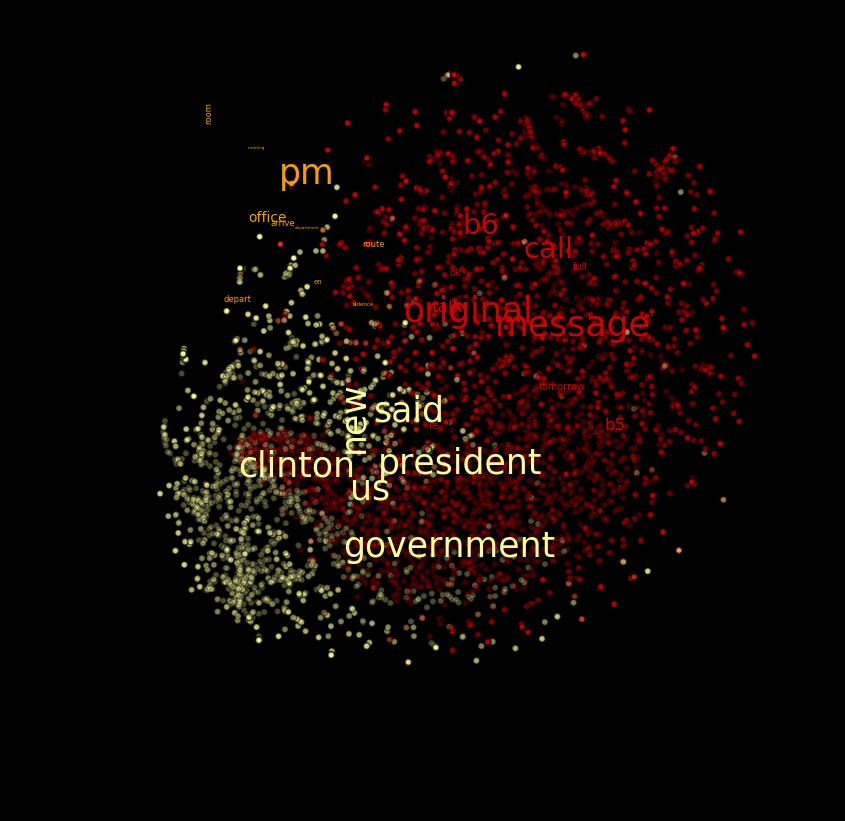

In [162]:
index_to_word = create_index_to_word_dict(vectorizer)
top_classes_words, top_words_scores = get_clouds_words(corpus,index_to_word, top_k=50)
show_words_clusters(X_tsne, y, top_classes_words, top_words_scores, figsize=(10,10), max_font=30, eps=-0.5)

# h

Качество я решила измерять с помощью кластерного коэффициента. Посмотрим, что если посчитать TF-IDF на выделенном тексте письма с удаленным мусором.

In [254]:
def make_clusters_and_show(data, clusterizer, decompositor, num_classes=3):
    print "making clusters..."
    y = clusterizer.fit_predict(data)
    print "doing decomposition..."
    X_show = decompositor.fit_transform(data)
    print "done"
    
    print "silhoute score: {}".format(silhouette_score(data, y))
    color_dict = cm.hot(np.linspace(0.3, 0.9, num_classes))
    plt.figure()
    plt.scatter(X_show[:,0], X_show[:,1], c=color_dict[y])
    plt.show()
    
    return X_show, y

In [206]:
vectorizer = TfidfVectorizer(max_features=1000)
corpus = vectorizer.fit_transform(data_to_analyze.ExtractedBodyText)

making clusters...
doing decomposition...
done
silhoute score: 0.0776857465267


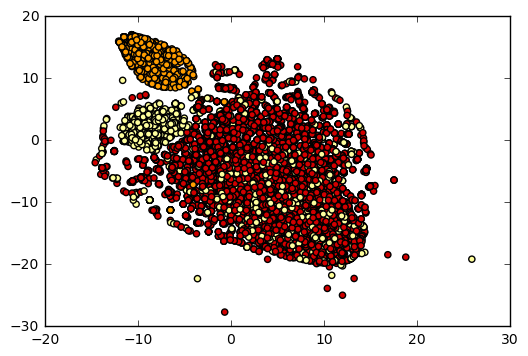

In [207]:
X_show, y = make_clusters_and_show(corpus, KMeans(n_clusters=3), TSNE(), num_classes=3)

/home/anya/.local/lib/python2.7/site-packages/ipykernel/__main__.py:31: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
/home/anya/.local/lib/python2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


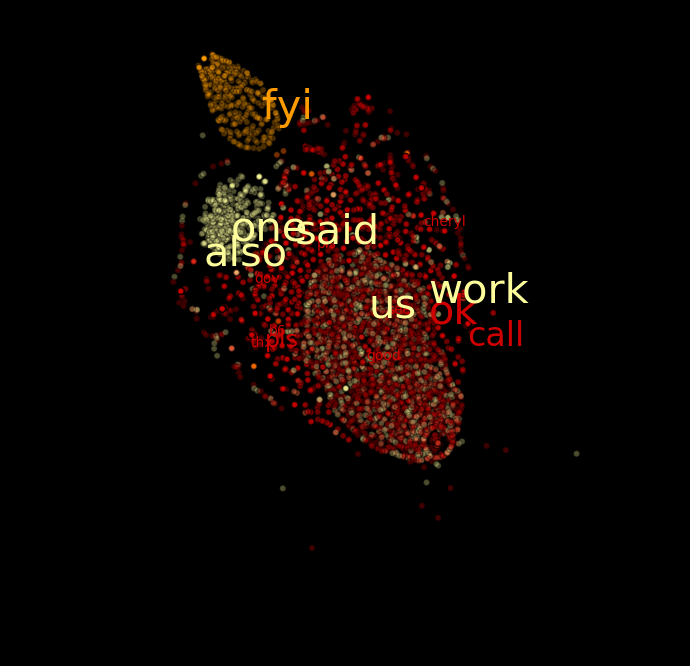

In [208]:
index_to_word = create_index_to_word_dict(vectorizer)
top_classes_words, top_words_scores = get_clouds_words(corpus, index_to_word, top_k=60)
show_words_clusters(X_show, y, top_classes_words, top_words_scores, max_font=35, figsize=(8,8), eps=-1.)

Оранжевый кластер неплохо выделился и главное слово там: FYI (For Your Interest). А если без удаления мусора:

making clusters...
doing decomposition...
done
silhoute score: 0.0761454281271


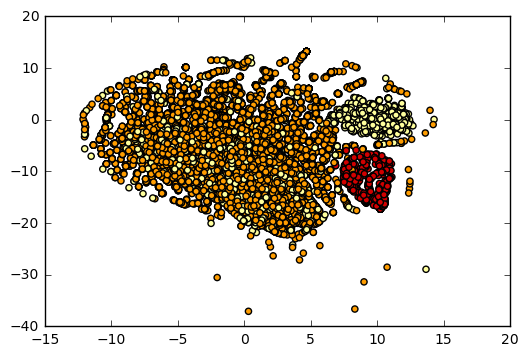

In [209]:
vectorizer = TfidfVectorizer(max_features=1000)
corpus = vectorizer.fit_transform(data.ExtractedBodyText.dropna())
X_show, y = make_clusters_and_show(corpus, KMeans(n_clusters=3), TSNE(), num_classes=3)

Попробуем добавить id отправителей.

In [231]:
vectorizer = TfidfVectorizer(max_features=1000)
corpus = vectorizer.fit_transform(data_to_analyze.ExtractedBodyText)
senders = pd.get_dummies(data_to_analyze.SenderPersonId).as_matrix()

In [251]:
new_data = np.concatenate([senders, corpus.todense()], axis=1)

making clusters...
doing decomposition...
done
silhoute score: 0.172506907908


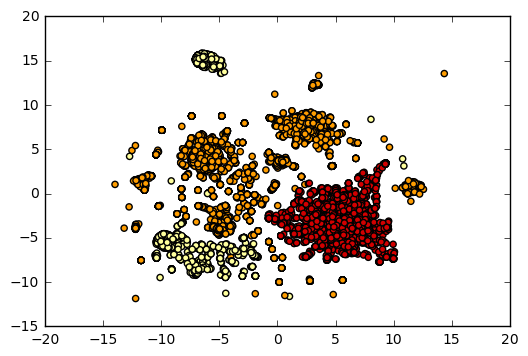

In [255]:
X_show, y = make_clusters_and_show(new_data, KMeans(n_clusters=3), TSNE(), num_classes=3)

Качество сразу подросло. На основе кластерного коэффициента определим оптимальное число кластеров.

In [301]:
from sklearn_numb_clusters import show_clusters_plot

('For n_clusters =', 2, 'The average silhouette_score is :', 0.12473470343979641)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.1725069079076301)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.20526890146118831)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.23411416339695074)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.24882198462710922)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.25988954277500381)
('For n_clusters =', 8, 'The average silhouette_score is :', 0.19001579735174584)
('For n_clusters =', 9, 'The average silhouette_score is :', 0.24779744160096209)


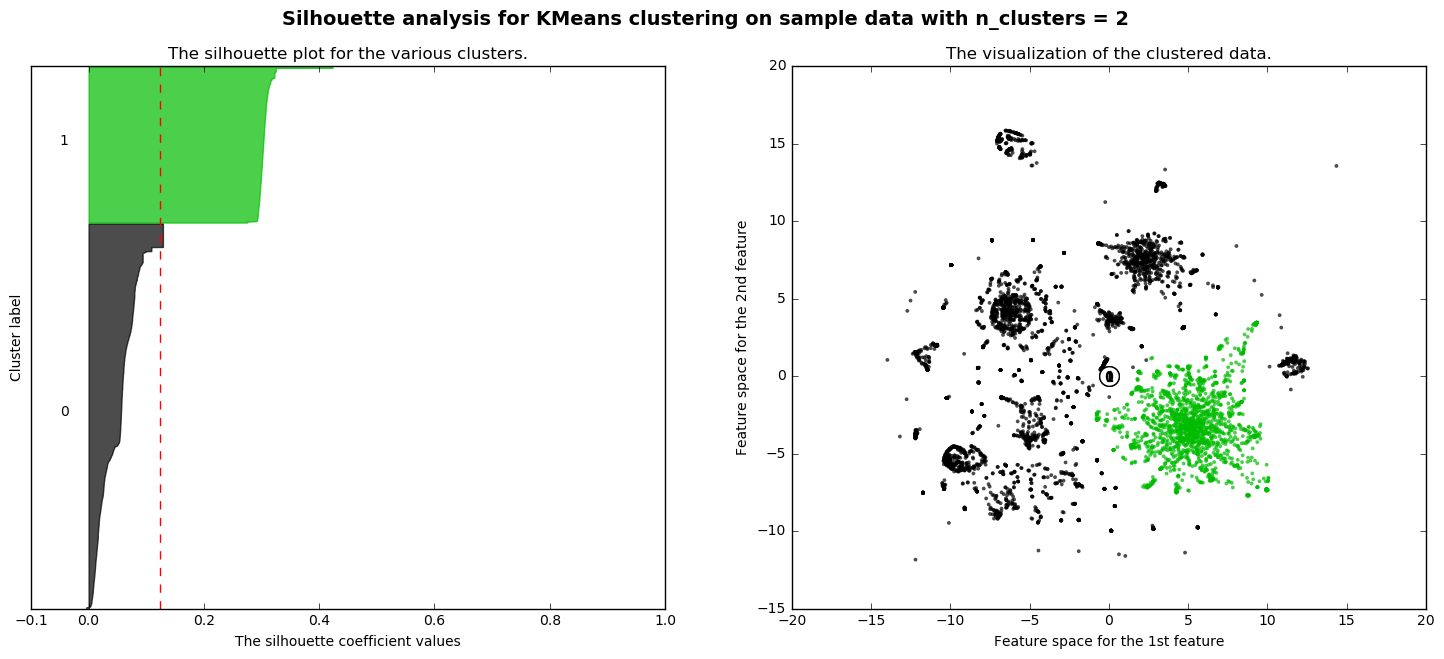

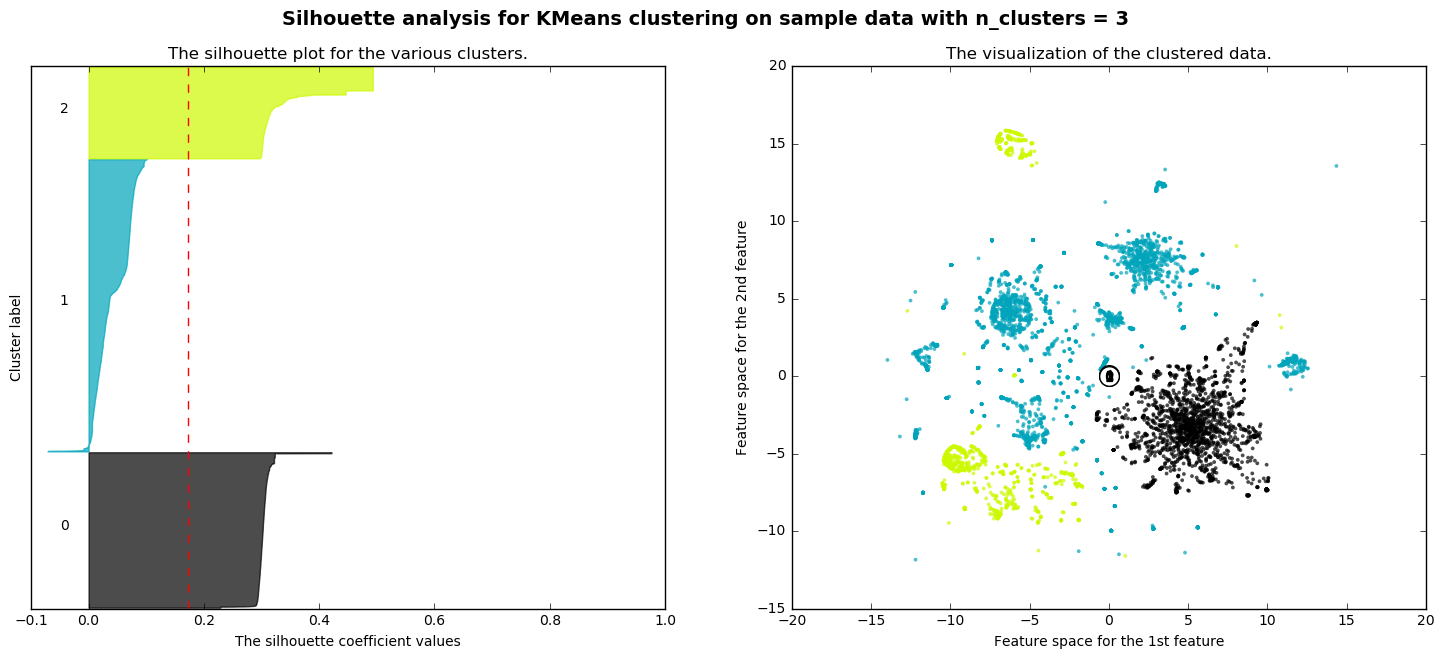

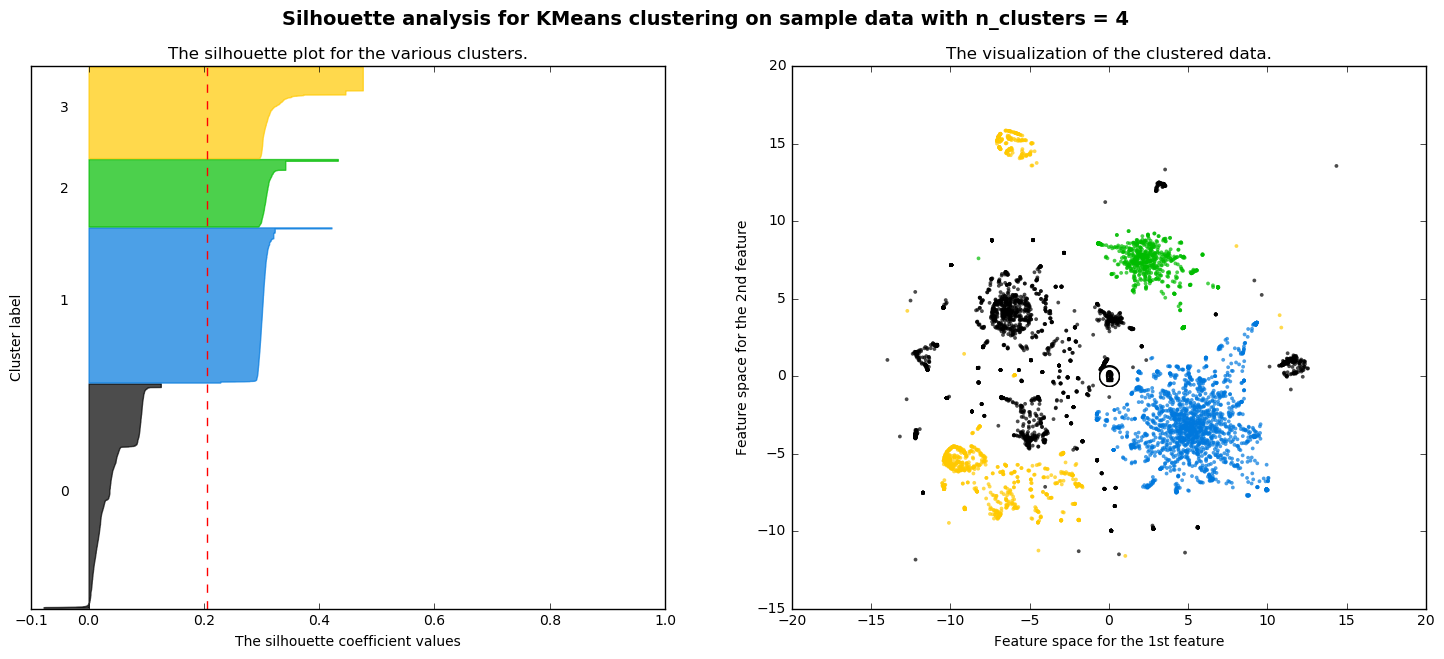

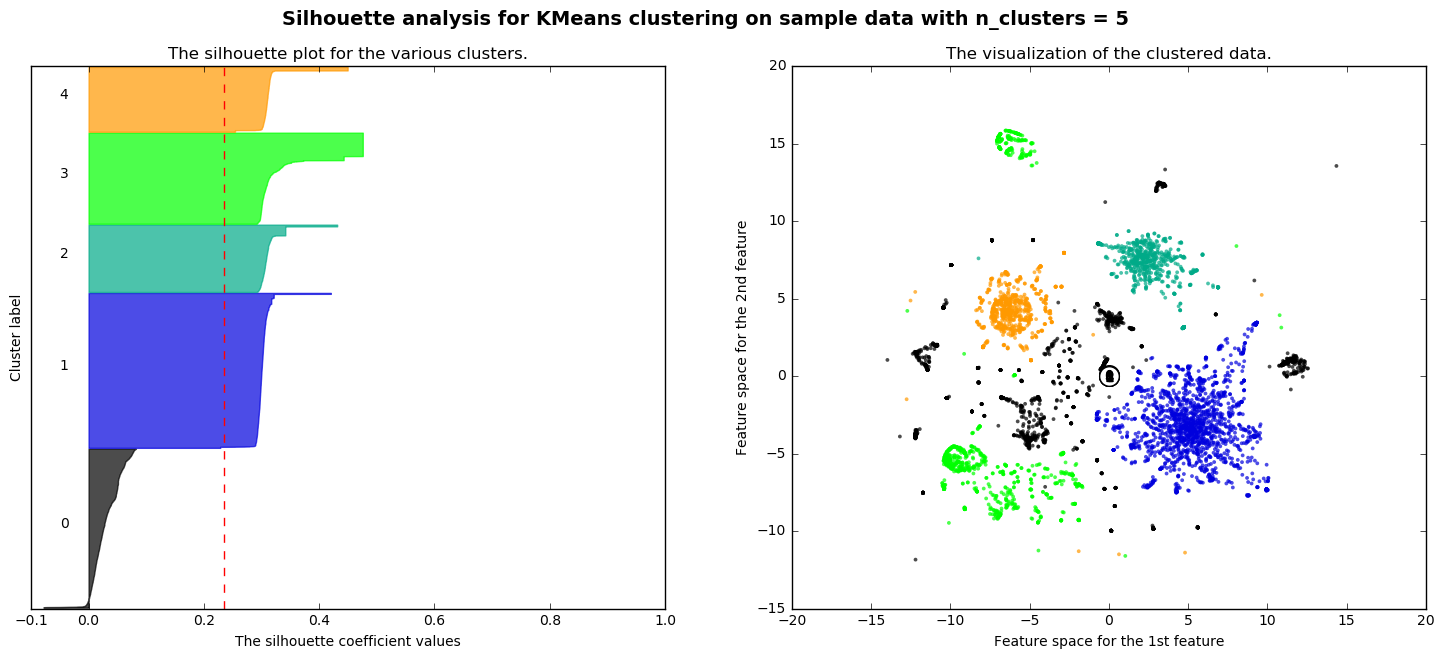

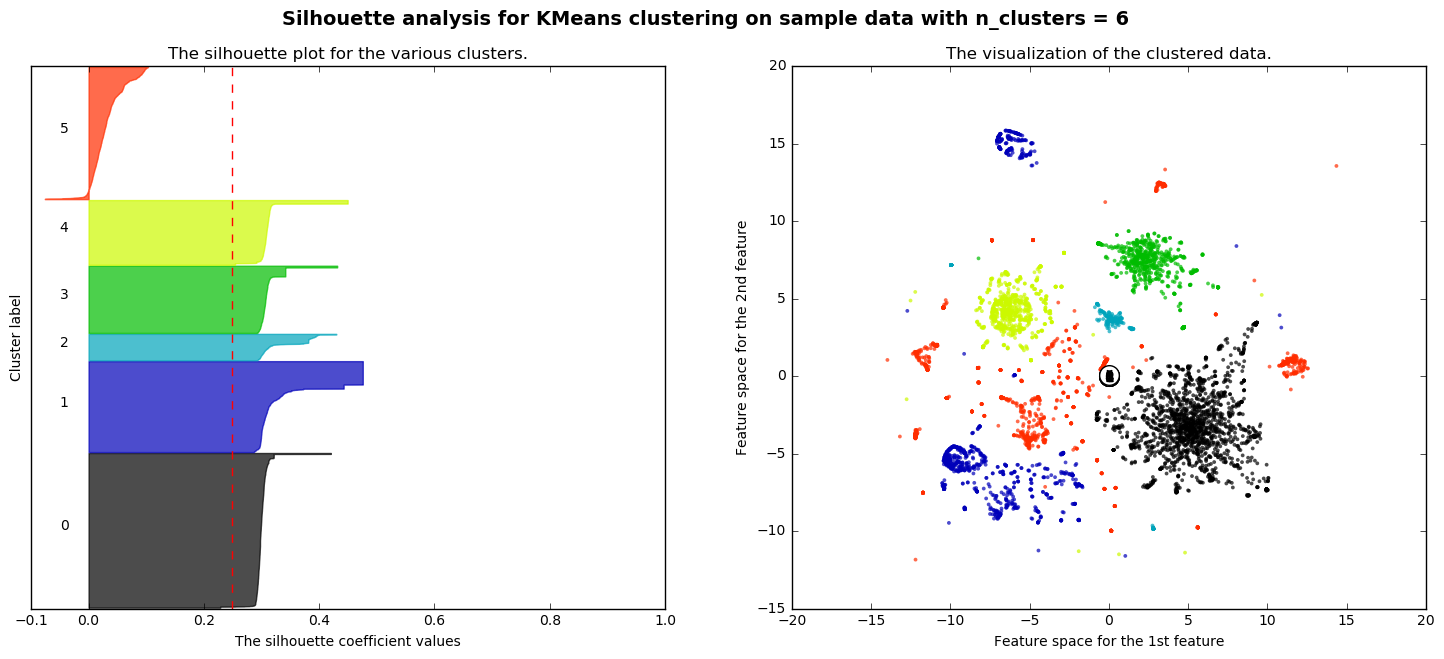

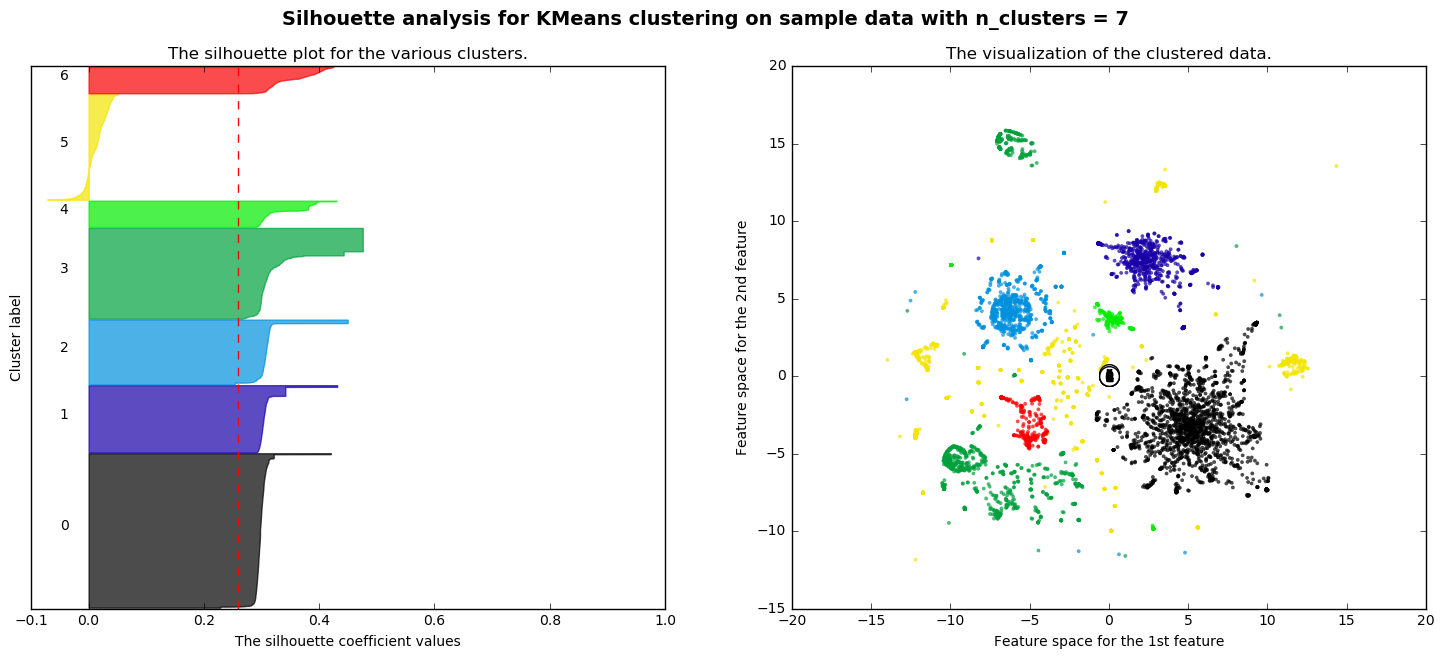

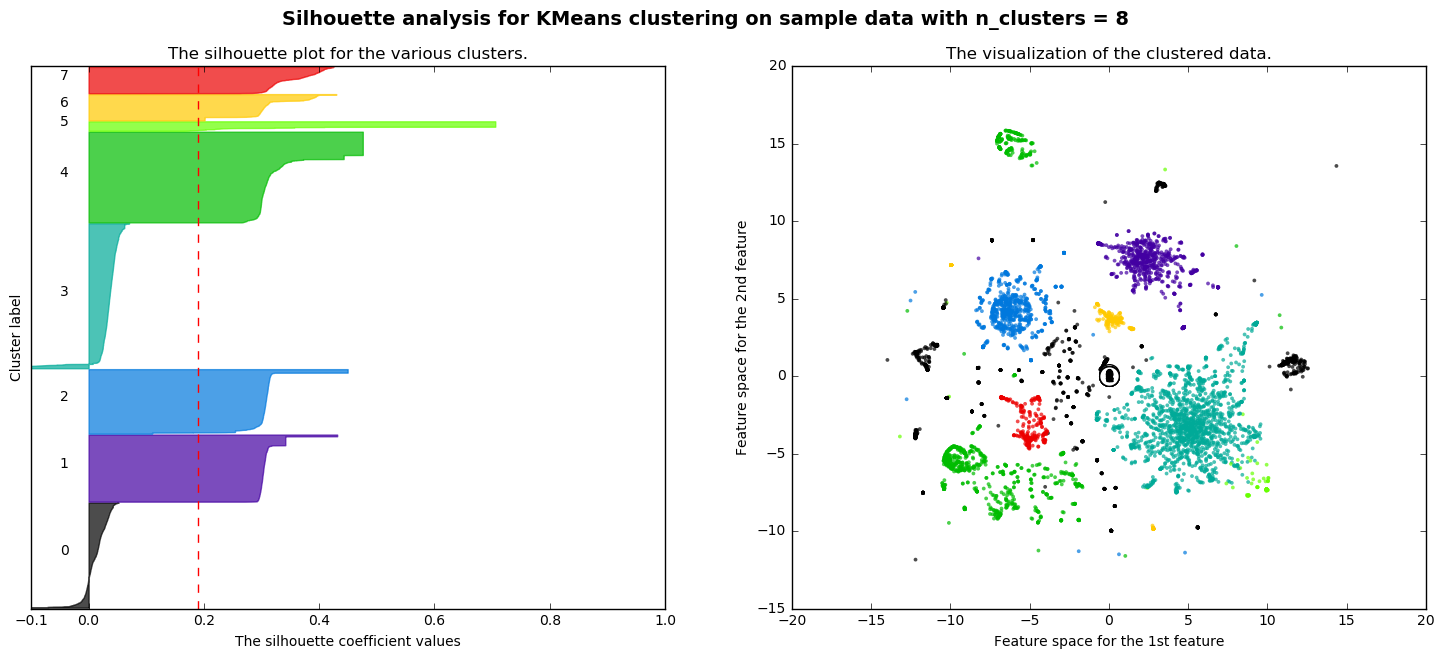

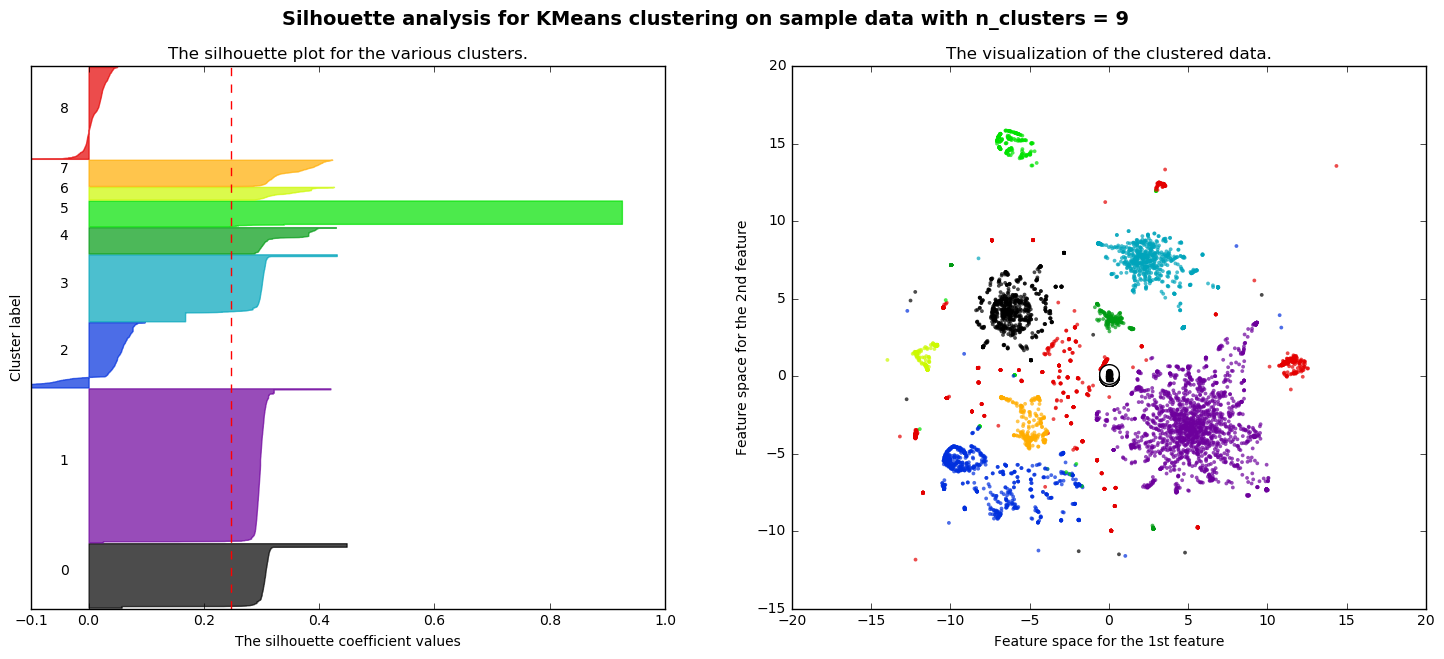

In [260]:
show_clusters_plot(new_data, X_show, range(2,10))

Идеальной картинки, когда минимум в каждом кластере ниже среднего, а максимум выше, не наблюдается. Более или менее оптимальным пока кажется брать 7 кластеров со средним кластерным коэффициентом 0.26. Добавим tf_idf на темах письма.

In [281]:
sub_vect = TfidfVectorizer(max_features=300)
subjects = sub_vect.fit_transform(data_to_analyze.MetadataSubject)
data_sub = np.concatenate([new_data, subjects.todense()], axis=1)
print data_sub.shape

(6433, 1404)


making clusters...
doing decomposition...
done
silhoute score: 0.165571416269


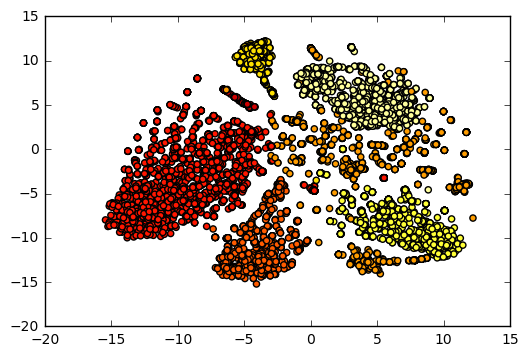

In [282]:
X_show_sub, y_sub = make_clusters_and_show(data_sub, KMeans(n_clusters=7), TSNE(), num_classes=7)

Темы письма не зашли. Попробуем учитывать еще дату письма.

In [298]:
years = map(lambda s: int(s[:4]), data_to_analyze.MetadataDateSent)
years_data = pd.get_dummies(years).as_matrix()
data_years = np.concatenate([new_data, years_data], axis=1)
data_years.shape

(6433, 1109)

making clusters...
doing decomposition...
done
silhoute score: 0.179166467957


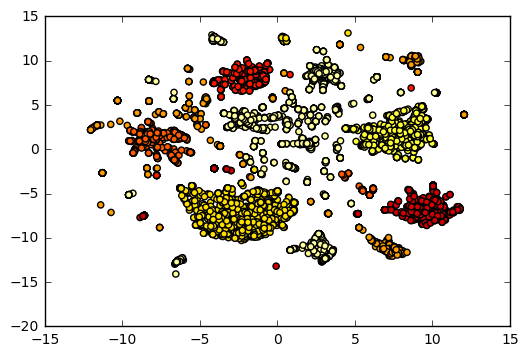

In [299]:
X_show_year, y_year = make_clusters_and_show(data_years, KMeans(n_clusters=7), TSNE(), num_classes=7)

Тоже стало похуже. Попробуем кластеризоывать чем-то более продвинутым, чем k-средних.

making clusters...
doing decomposition...
done
silhoute score: 0.259889542775


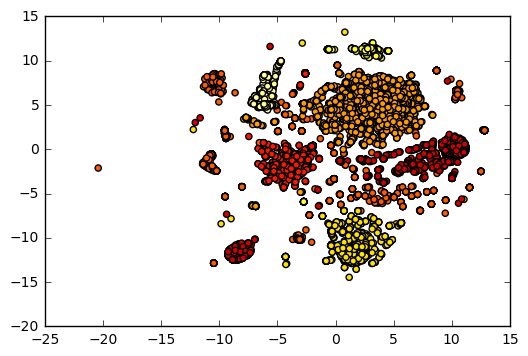

In [302]:
X_show, y = make_clusters_and_show(new_data, AgglomerativeClustering(n_clusters=7), TSNE(), num_classes=7)

Агломеративная кластеризация дала примерно такой же результат. Попробуем чуть понизить размерность и потом уже кластеризовывать.

In [318]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(new_data)

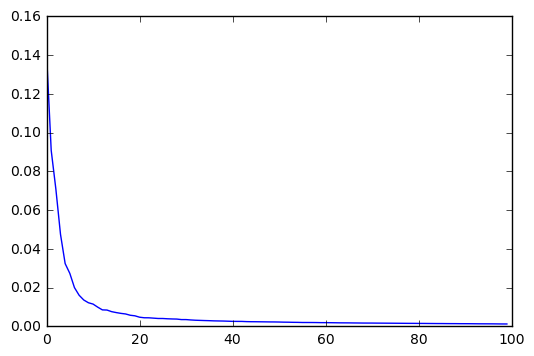

In [319]:
plt.plot(pca.explained_variance_ratio_)

making clusters...
doing decomposition...
done
silhoute score: 0.338872033315


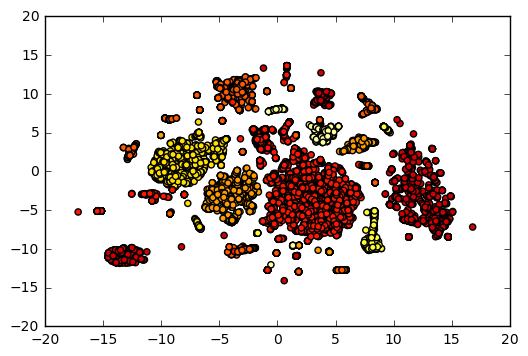

In [320]:
X_show, y = make_clusters_and_show(X_pca, AgglomerativeClustering(n_clusters=7), TSNE(), num_classes=7)

('For n_clusters =', 5, 'The average silhouette_score is :', 0.32776451794315314)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.34574573785514973)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.36006631726364413)
('For n_clusters =', 8, 'The average silhouette_score is :', 0.36613559965275794)
('For n_clusters =', 9, 'The average silhouette_score is :', 0.36085102347705167)


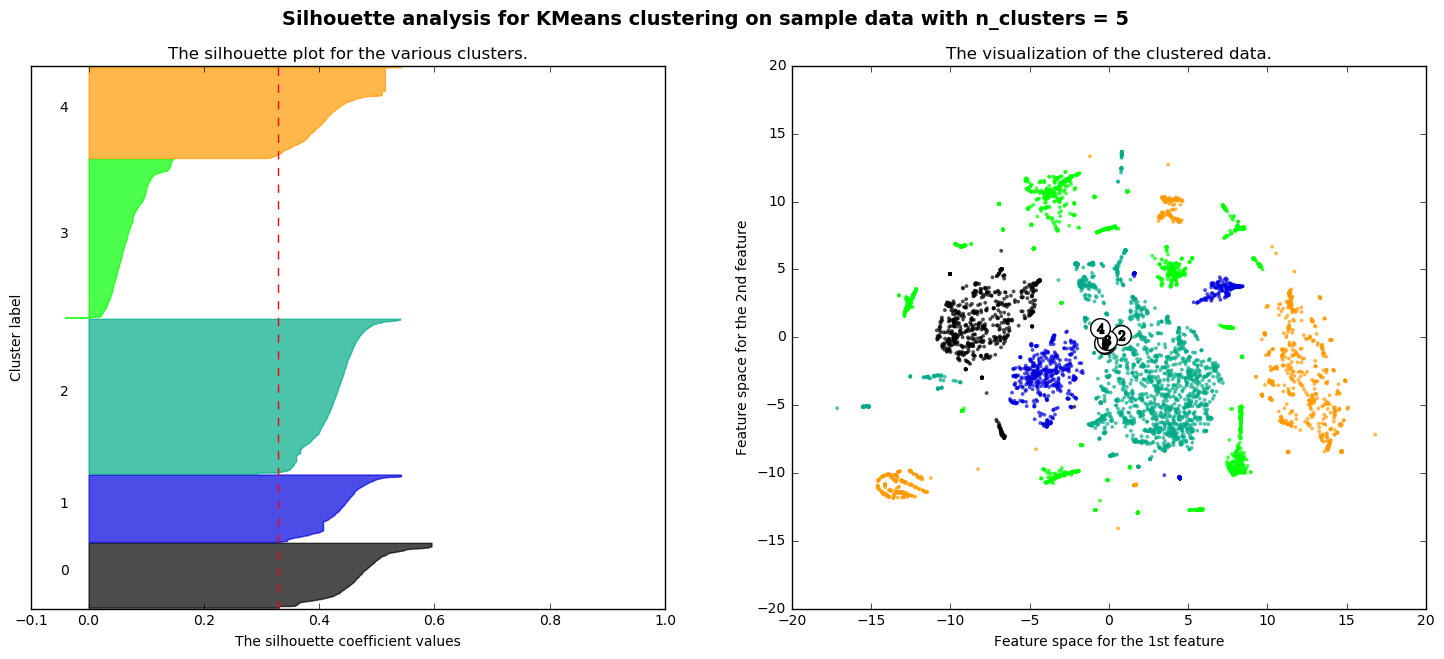

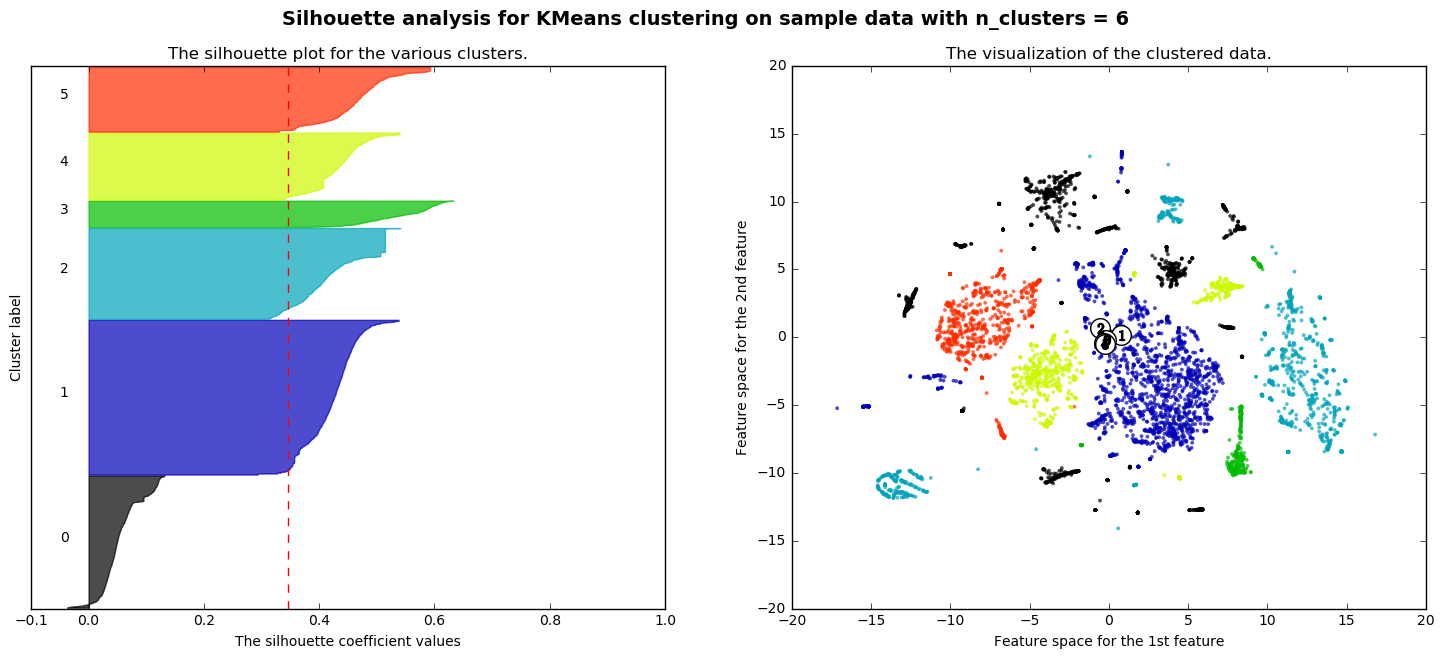

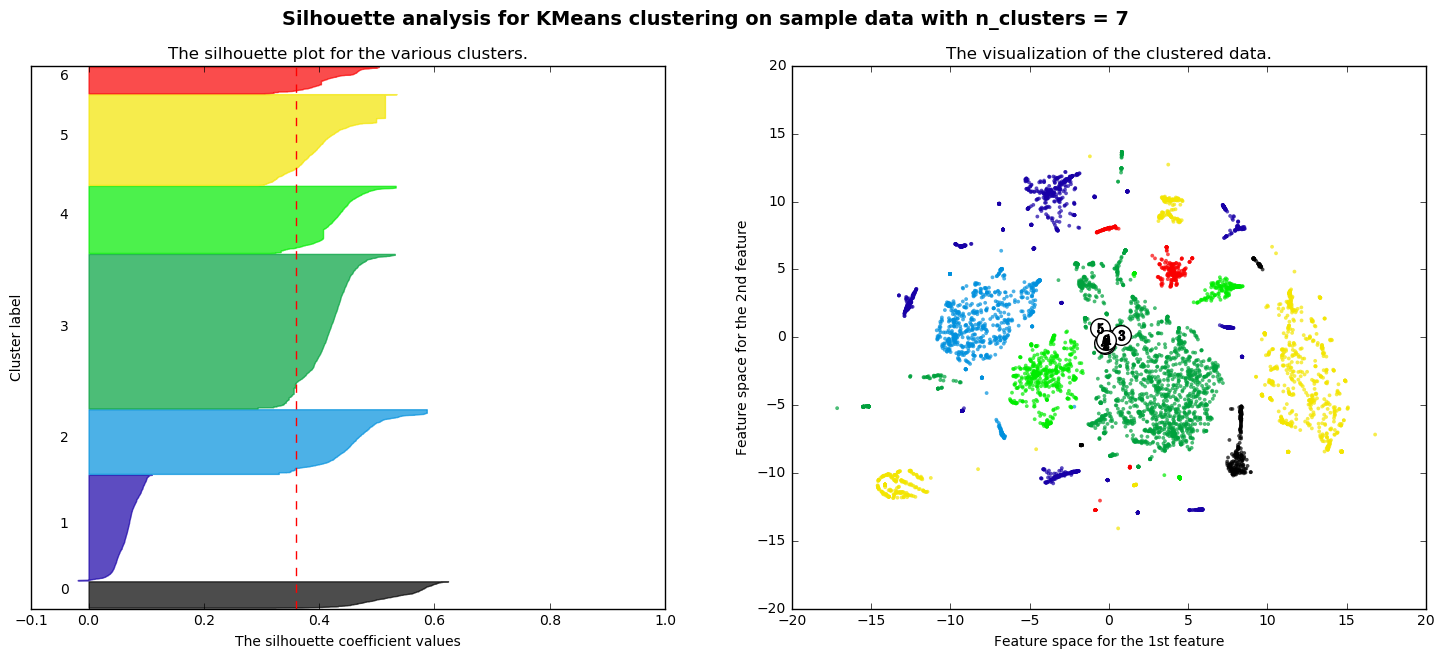

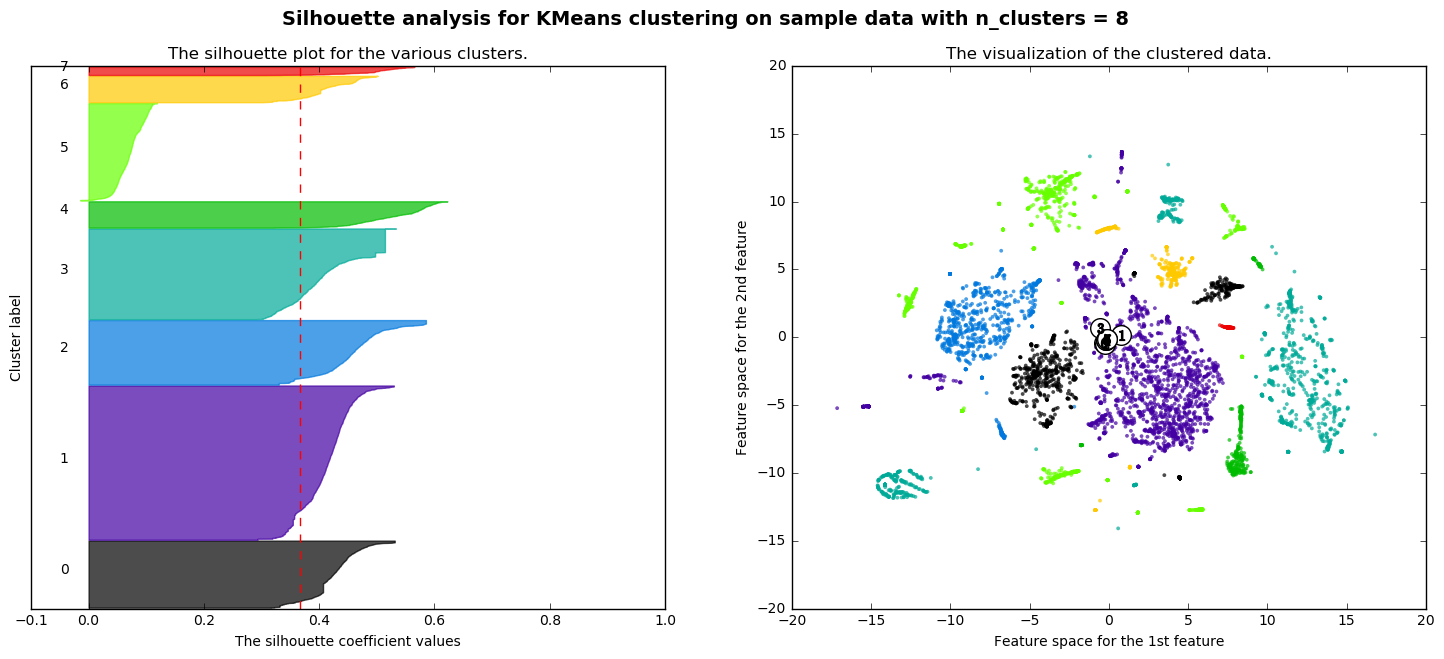

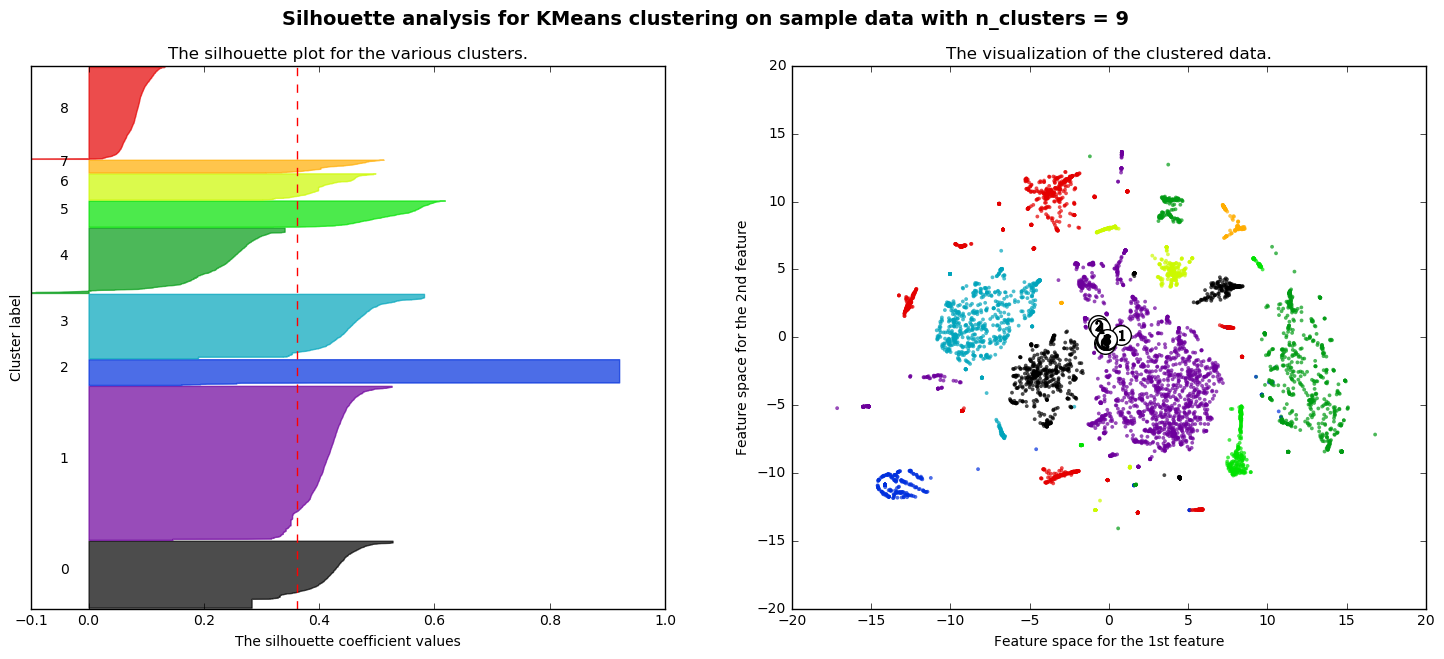

In [329]:
show_clusters_plot(X_pca, X_show, [5,6,7,8,9])

Теперь лучший скор - 0.366 с 8 кластерами. Визуализируем 

making clusters...
doing decomposition...
done
silhoute score: 0.367450587336


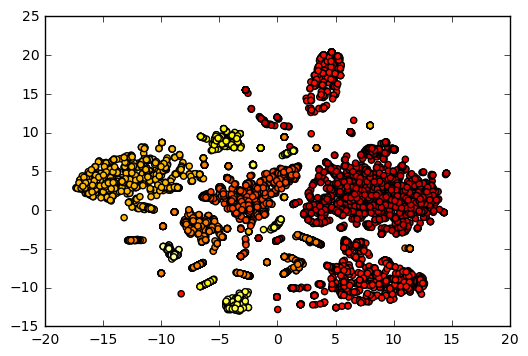

In [395]:
X_show, y = make_clusters_and_show(X_pca, KMeans(n_clusters=8), TSNE(), num_classes=8)

/home/anya/.local/lib/python2.7/site-packages/ipykernel/__main__.py:31: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
/home/anya/.local/lib/python2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


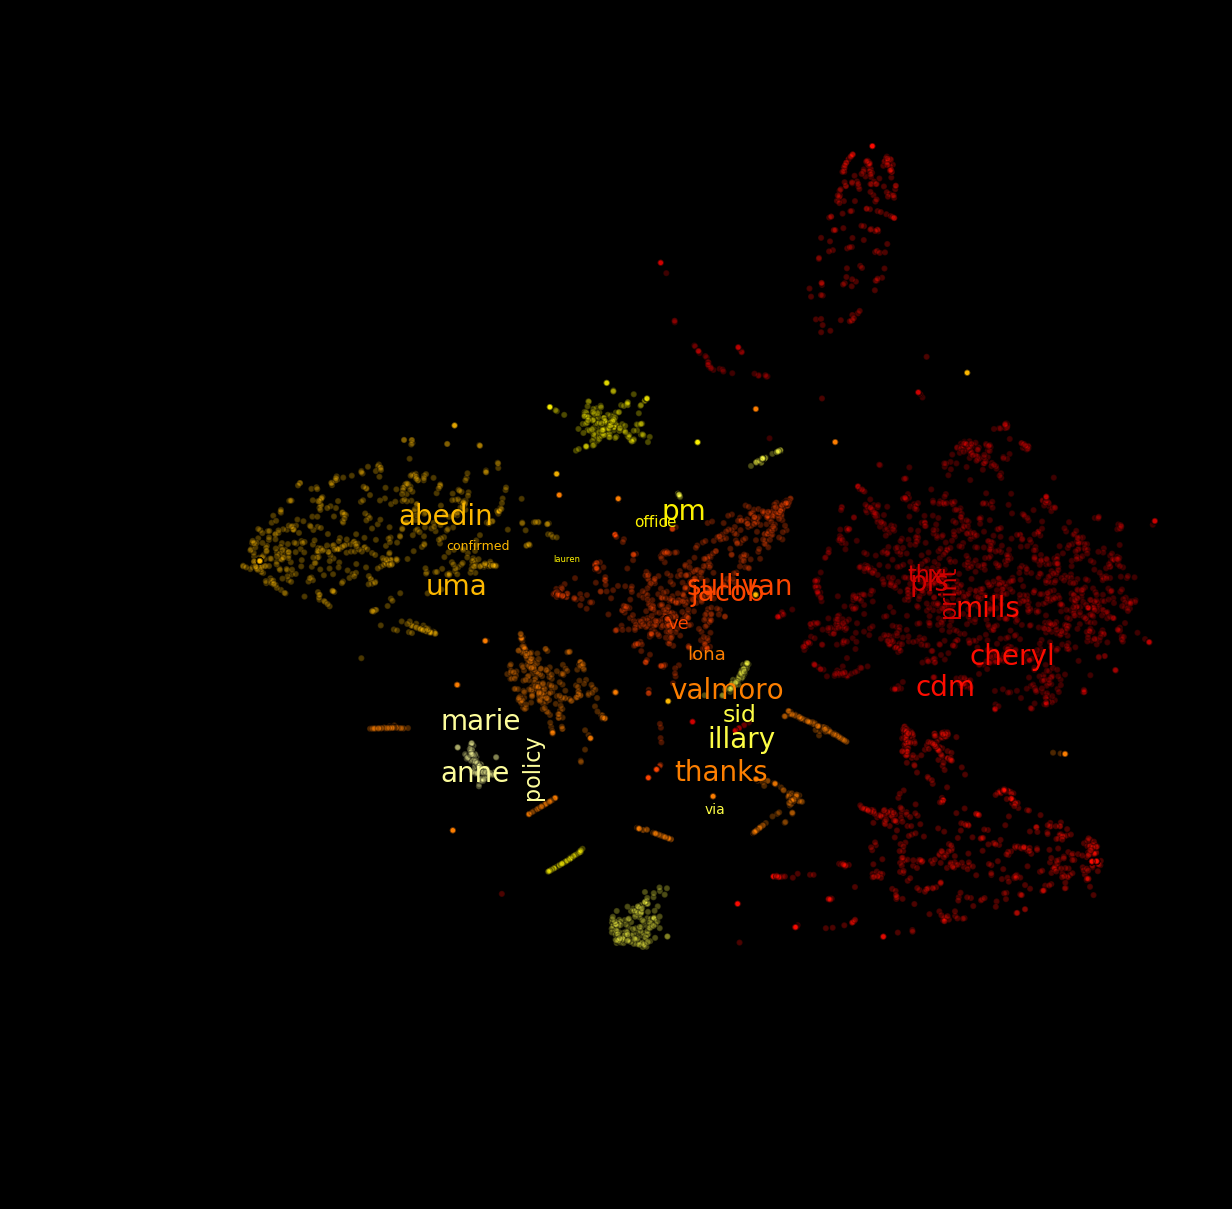

In [450]:
index_to_word = create_index_to_word_dict(vectorizer)
top_classes_words, top_words_scores = get_clouds_words(corpus, index_to_word, top_k=50, num_classes=8)
show_words_clusters(X_show, y, top_classes_words, top_words_scores,
                    max_font=25, figsize=(15,15), eps=-1., max_words_in_cloud=3, centr_coef=0.3)

Облака слов для каждого из 8 классов.

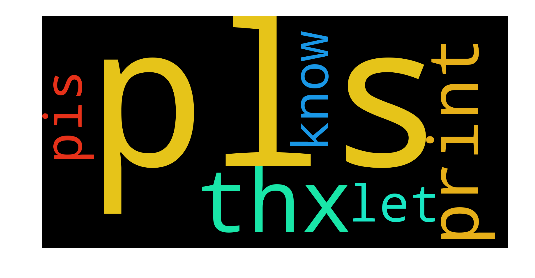

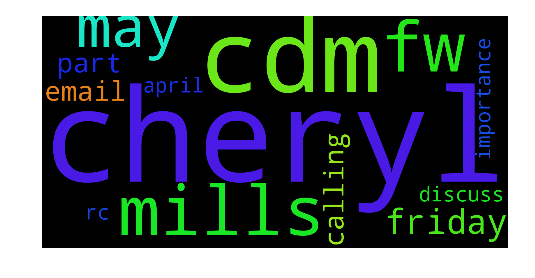

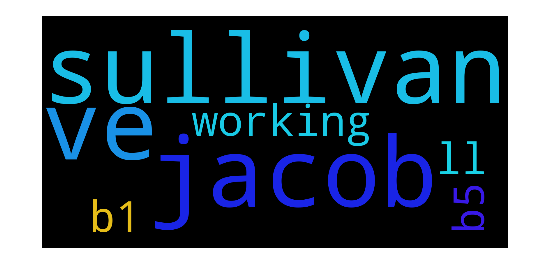

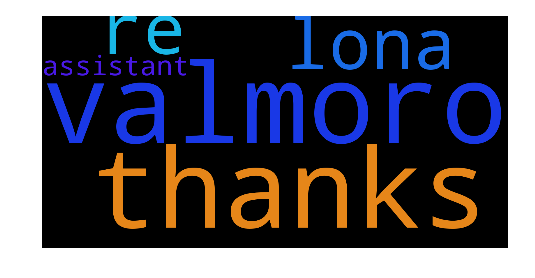

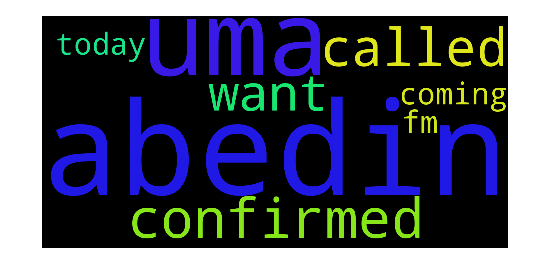

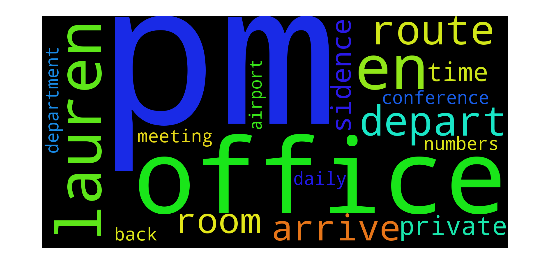

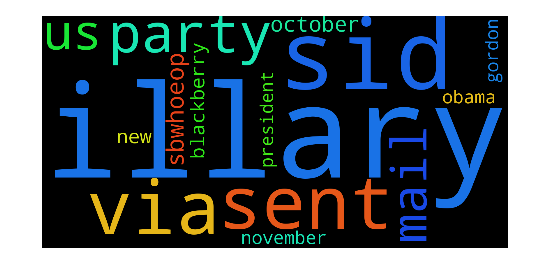

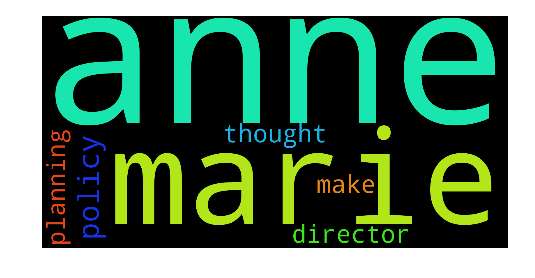

In [451]:
for class_id in range(8):
    class_words_fr_str = create_frequency_string(top_classes_words[class_id], top_words_scores)
    wcloud = WordCloud(height=800, width=1600).generate(class_words_fr_str)

    # print class_words_fr_str
    plt.imshow(wcloud)
    plt.axis('off')
    plt.show()

In [452]:
data_to_analyze.label = y

Сгенерируем вопросы для асессоров. Вопросы вида -- три письма из одного класса, одно из другого. Надо выбрать то письмо, которое относится к другому классу.

In [528]:
centres = np.array([])
classes_ind = list()

for class_numb in range(8):
    center = list([X_pca[np.where(y == class_numb)].mean(axis=0),])
    distances = zip(list(np.where(y == class_numb)[0]), 
                    np.mean((X_pca[np.where(y == class_numb)] - center) ** 2, axis = 1))
    
    distances.sort(key = lambda x: x[1])
    classes_ind.append([x[0] for x in distances[:20]])

In [529]:
subjects = list(data_to_analyze.MetadataSubject)
letters = list(data_to_analyze.ExtractedBodyText)

In [532]:
answers = [3, 2, 1, 3, 2, 1, 1, 2]
for class_id in range(8):
    print "Question number {}".format(class_id + 1)
    print
    other = range(8)
    other.remove(class_id)
    other_class = choice(other)
    ind_to_print = choice(classes_ind[class_id], 3)
    
    k = -1
    for j in range(4):
    
        if j == answers[class_id]:
            print subjects[classes_ind[class_id-1][0]]
            print letters[classes_ind[class_id-1][0]]
            print "------------------------------------------------"
    
        else:
            k += 1
            print subjects[ind_to_print[k]]
            print
            print letters[ind_to_print[k]]
            print "--------------------------------------------"

Question number 1

CALL LIST

Take off:
ariri
Sulayman
Papandreou
Ashton
Abbas
Gheit
Faisal
Amorim
Posner
Schuster
Solis
--------------------------------------------
SAUDI GRAND MUFTI CALLS ATTACKS ON FOREIGN EMBASSIES UN-ISLAMIC (REUTERS)

I thanked Prince Saud.
--------------------------------------------
TEST

ceived.
--------------------------------------------
OUTCOME OF THE ENTREPRENEURSHIP SUMMIT
ere is a quite different picture of the Middle East — and an example of our leading in a different way. NB also the
woman entrepreneur from Dubai. AM
------------------------------------------------
Question number 2

MEANT TO EMAIL EARLIER

----
--------------------------------------------
ADMINISTRATION SHOULD INCLUDE EDUCATION ASSISTANCE IN SUPPLEMENTAL FUNDING REQUEST FOR HAITI, LUGAR SAYS

request for aiti, Lugar says
FYI
--------------------------------------------
SAUDI GRAND MUFTI CALLS ATTACKS ON FOREIGN EMBASSIES UN-ISLAMIC (REUTERS)
I thanked Prince Saud.
--------------------

## Вывод

Соседка по комнате ответила правильно на 4 вопроса из 8. Не очень плохо, но и не очень хорошо. Для подбора алгоритма и признаков я использовала кластерный коэффициент, финальный резульат: 0.37.